# Stencil Computation for 2D Gray-Scott Using Julia 

In [1]:
#using Pkg
#Pkg.add("CUDA")

In [2]:
#import Pkg
#Pkg.add("BenchmarkTools")

In [3]:
#import Pkg
#Pkg.add("ProgressMeter")

In [4]:
#import Pkg
#Pkg.add("KernelAbstractions")

In [5]:
#import Pkg
#Pkg.add("Plots")
#Pkg.add("ColorTypes")

In [6]:
using CUDA # for NVIDIA GPU access

In [7]:
using BenchmarkTools # for benchmarking

In [8]:
using ProgressMeter # for progress monitoring

In [9]:
using Plots, ColorTypes # for plotting

When using CUDA.jl on a new system, you should always check if the package is functional as is able to utilize your GPUs correctly. To do this, you can call the `CUDA.versioninfo()` function. Like `Base.versioninfo()`, this will print some information on the available hardware and loaded libraries:

In [10]:
CUDA.versioninfo()

CUDA runtime 12.6, artifact installation
CUDA driver 12.4
NVIDIA driver 550.54.15

CUDA libraries: 
- CUBLAS: 12.6.3
- CURAND: 10.3.7
- CUFFT: 11.3.0
- CUSOLVER: 11.7.1
- CUSPARSE: 12.5.4
- CUPTI: 2024.3.2 (API 24.0.0)
- NVML: 12.0.0+550.54.15

Julia packages: 
- CUDA: 5.5.2
- CUDA_Driver_jll: 0.10.3+0
- CUDA_Runtime_jll: 0.15.3+0

Toolchain:
- Julia: 1.10.6
- LLVM: 15.0.7

3 devices:
  0: Tesla V100S-PCIE-32GB (sm_70, 31.729 GiB / 32.000 GiB available)
  1: Tesla P100-PCIE-16GB (sm_60, 15.886 GiB / 16.000 GiB available)
  2: NVIDIA GeForce GTX 1080 Ti (sm_61, 10.899 GiB / 11.000 GiB available)


# Gray-Scott Reaction-Diffusion Model

The Gray-Scott Reaction-Diffusion model is a mathematical model used to describe how two interacting substances, typically denoted as $U$ and $V$, evolve over time in a spatial domain. This model captures the combined effects of chemical reactions and diffusion, leading to complex pattern formations such as spots, stripes, and waves, which resemble natural phenomena like animal skin patterns or chemical reactions in a petri dish.

## Equations

The evolution of $ U $ and $ V $ over time is described by the following partial differential equations (PDEs):

$$
\frac{\partial U}{\partial t} = D_u \nabla^2 U - UV^2 + F(1 - U)
$$

$$
\frac{\partial V}{\partial t} = D_v \nabla^2 V + UV^2 - (F + k)V
$$

- **$D_u$**: Diffusion coefficient of $U$, controlling its spread rate.
- **$D_v$**: Diffusion coefficient of $V$, controlling its spread rate.
- **$F$**: Feed rate of  $U$, representing the replenishment of  $U$ in the system.
- **$ k $**: Kill rate of $V$, representing the removal of $V$ from the system.
- **$ \nabla^2 $**: Laplacian operator, representing the diffusion term.

# 2D 5-Point Stencil in the Gray-Scott Reaction-Diffusion Model

The 2D 5-point stencil is used to compute the diffusion terms ($ D_u \nabla^2 U $ and $ D_v \nabla^2 V $) in the Gray-Scott reaction-diffusion equations. It helps model how the substances $ U $ and $V $ spread through the 2D spatial domain by capturing the local flow of concentration between neighboring points.



## Mathematical Formulation

The Laplacian of a function $ u $ at point $(i, j)$ using the 2D 5-point stencil is approximated as:



$$
\nabla^2 u_{i, j} \approx \frac{1}{h^2} \left( u_{i-1, j} + u_{i+1, j} - 2 \cdot u_{i, j} \right) + \frac{1}{h^2} \left( u_{i, j-1} + u_{i, j+1} - 2 \cdot u_{i, j} \right)
$$

- **$ h $** is the grid spacing.
- The approximation relies on the difference between the central point and its neighbors, scaled by the grid spacing.

## CPU (Single-Threaded) Implementation of the Gray-Scott Equation

In [11]:
function laplacian(A, x, y, dx)
    @inbounds DAx = (A[x-1, y] - 2.0 * A[x, y] + A[x+1, y]) / dx
    @inbounds DAy = (A[x, y-1] - 2.0 * A[x, y] + A[x, y+1]) / dx
    return DAx + DAy
end

laplacian (generic function with 1 method)

In [12]:
function calculate_gs_cpu!(U, V, D_u, D_v, F, k, dt, dx, nx, ny)
    # Allocate some temporary arrays for Laplacian results
    ΔU = zeros(nx, ny)
    ΔV = zeros(nx, ny)

    # Compute diffusion
    for x in 2:(nx-1), y in 2:(ny-1)
        @inbounds ΔU[x, y] = laplacian(U, x, y, dx)
        @inbounds ΔV[x, y] = laplacian(V, x, y, dx)
    end

    # Compute and update concentration fields
    UVV = U .* V .* V
    U .+= (D_u .* ΔU .- UVV .+ F .* (1 .- U)) .* dt
    V .+= (D_v .* ΔV .+ UVV .- (F .+ k) .* V) .* dt
    
    return
end
function simulate_gs_cpu(n = 500 #=Grid size=#, nsteps = 10000 #=Number of iterations=#)
    # Initialize parameters
    D_u = 0.16         # Diffusion rate of U
    D_v = 0.08         # Diffusion rate of V
    F = 0.035          # Feed rate
    k = 0.06           # Kill rate
    dt = 1.0           # Time step
    dx = 1.0           # Spatial step
    plot_every = 500   # Plot every 500 steps
    
    # Initialize concentration fields U and V
    U = rand(0.0:0.001:0.1, n, n)
    V = zeros(n, n)

    # Set up an initial small disturbance
    n_mid = div(n, 2)
    U[n_mid-5:n_mid+5, n_mid-5:n_mid+5] .= 0.5
    V[n_mid-5:n_mid+5, n_mid-5:n_mid+5] .= 0.25

    # Set up a progress bar
    prog = Progress(div(nsteps, plot_every))

    # Set up a figure for the heatmaps
    plt = Plots.plot(title="Gray-Scott Model", xlabel="X", ylabel="Y", size=(600, 600))

    # Simulation loop
    anim = Plots.@animate for T in 1:div(nsteps, plot_every)
        # Update the U and V concentrations
        for t in 1:plot_every
            calculate_gs_cpu!(U, V, D_u, D_v, F, k, dt, dx, n, n)
        end
        
        # Update the progress bar
        next!(prog)

        # Plot the current U concentrations
        Plots.heatmap!(plt, U, color=cgrad([:black, :blue, :white]), clims=(0, 1), title="Gray-Scott Model")
    end
    gif(anim, "gs_cpu_serial.gif"; fps=10)
end

simulate_gs_cpu (generic function with 3 methods)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


100.962099 seconds (425.98 M allocations: 69.430 GiB, 3.26% gc time, 6.11% compilation time: 29% of which was recompilation)


[ Info: Saved animation to /home/jpsamaroo/julia-hpc-tutorial-sc24/parts/gpu/gs_cpu_serial.gif


Plots.AnimatedGif("/home/jpsamaroo/julia-hpc-tutorial-sc24/parts/gpu/gs_cpu_serial.gif")
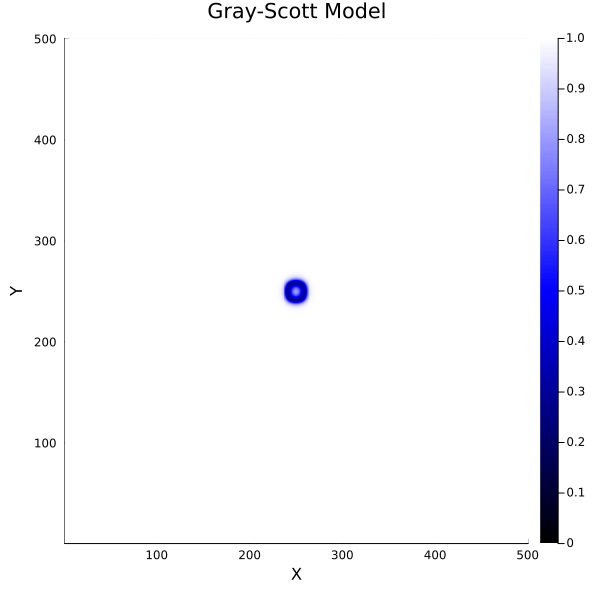

In [13]:
@time simulate_gs_cpu(500, 10000)

## CPU (Multi-Threaded) Implementation of the Gray-Scott Equation

In [14]:
function calculate_gs_cpu_mt!(U, V, D_u, D_v, F, k, dt, dx, nx, ny)
    # Allocate U and V temporaries for updates
    DU = Matrix{Float64}(undef, nx, ny)
    DV = Matrix{Float64}(undef, nx, ny)

    # Compute diffusion and concentration fields changes
    Threads.@threads for y in 2:(ny-1)
        for x in 2:(nx-1)
            # Compute diffusion
            ΔU = laplacian(U, x, y, dx)
            ΔV = laplacian(V, x, y, dx)

            # Compute concentration fields changes
            UVV = @inbounds U[x, y] * (V[x, y] ^ 2)
            @inbounds DU[x, y] = D_u * ΔU - UVV + F * (1 - U[x, y])
            @inbounds DV[x, y] = D_v * ΔV + UVV - (F + k) * V[x, y]
        end
    end

    # Update concentration fields
    Threads.@threads for y in 2:(ny-1)
        for x in 2:(nx-1)
            @inbounds U[x, y] += DU[x, y] * dt
            @inbounds V[x, y] += DV[x, y] * dt
        end
    end
    
    return
end
function simulate_gs_cpu_mt(n = 500 #=Grid size=#, nsteps = 10000 #=Number of iterations=#)
    # Initialize parameters
    D_u = 0.16         # Diffusion rate of U
    D_v = 0.08         # Diffusion rate of V
    F = 0.035          # Feed rate
    k = 0.06           # Kill rate
    dt = 1.0           # Time step
    dx = 1.0           # Spatial step
    plot_every = 500   # Plot every 500 steps
    
    # Initialize concentration fields U and V
    U = rand(0.0:0.001:0.1, n, n)
    V = zeros(n, n)

    # Set up an initial small disturbance
    n_mid = div(n, 2)
    U[n_mid-5:n_mid+5, n_mid-5:n_mid+5] .= 0.5
    V[n_mid-5:n_mid+5, n_mid-5:n_mid+5] .= 0.25

    # Set up a progress bar
    prog = Progress(div(nsteps, plot_every))

    # Set up a figure for the heatmaps
    plt = Plots.plot(title="Gray-Scott Model", xlabel="X", ylabel="Y", size=(600, 600))

    # Simulation loop
    anim = Plots.@animate for T in 1:div(nsteps, plot_every)
        # Update the U and V concentrations
        for t in 1:plot_every
            calculate_gs_cpu_mt!(U, V, D_u, D_v, F, k, dt, dx, n, n)
        end
        
        # Update the progress bar
        next!(prog)

        # Plot the current U concentrations
        Plots.heatmap!(plt, U, color=cgrad([:black, :blue, :white]), clims=(0, 1), title="Gray-Scott Model")
    end
    gif(anim, "gs_cpu_mt.gif"; fps=10)
end

simulate_gs_cpu_mt (generic function with 3 methods)

In [ ]:
@time simulate_gs_cpu_mt(500, 10000)

Progress:  75%|██████████████████████████████▊          |  ETA: 0:00:13

## GPU (CUDA) Implementation of the Gray-Scott Equation

In [ ]:
function calculate_gs_cuda!(U, V, D_u, D_v, F, k, dt, dx, nx, ny)
    x = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    y = (blockIdx().y - 1) * blockDim().y + threadIdx().y

    # Skip ghost cells on the boundaries
    if (1 < x < nx) && (1 < y < ny)
        # Compute diffusion
        ΔU = laplacian(U, x, y, dx)
        ΔV = laplacian(V, x, y, dx)

        # Update concentration fields
        UVV = @inbounds U[x, y] * (V[x, y] ^ 2)
        DU = @inbounds D_u * ΔU - UVV + F * (1 - U[x, y])
        DV = @inbounds D_v * ΔV + UVV - (F + k) * V[x, y]

        # Wait for all threads to read U and V
        CUDA.sync_threads()

        # Update concentration fields
        @inbounds U[x, y] += DU * dt
        @inbounds V[x, y] += DV * dt

        # Wait for all threads to write U and V
        CUDA.sync_threads()
    end
    
    return
end
function simulate_gs_cuda(n = 500 #=Grid size=#, nsteps = 10000 #=Number of iterations=#)
    # Initialize parameters
    D_u = 0.16         # Diffusion rate of U
    D_v = 0.08         # Diffusion rate of V
    F = 0.035          # Feed rate
    k = 0.06           # Kill rate
    dt = 1.0           # Time step
    dx = 1.0           # Spatial step
    plot_every = 500   # Plot every 500 steps
    
    # Initialize concentration fields U and V
    U = rand(0.0:0.001:0.1, n, n)
    V = zeros(n, n)

    # Set up an initial small disturbance
    n_mid = div(n, 2)
    U[n_mid-5:n_mid+5, n_mid-5:n_mid+5] .= 0.5
    V[n_mid-5:n_mid+5, n_mid-5:n_mid+5] .= 0.25
    
    # Transfer to the GPU
    U_gpu = CuArray(U)
    V_gpu = CuArray(V)

    # Set up a progress bar
    prog = Progress(div(nsteps, plot_every))

    # Set up a figure for the heatmaps
    plt = Plots.plot(title="Gray-Scott Model", xlabel="X", ylabel="Y", size=(600, 600))

    # Simulation loop
    anim = Plots.@animate for T in 1:div(nsteps, plot_every)
        # Update the U and V concentrations
        for t in 1:plot_every
            @cuda threads=(16, 16) blocks=(cld(n, 16), cld(n, 16)) calculate_gs_cuda!(U_gpu, V_gpu, D_u, D_v, F, k, dt, dx, n, n)
        end
        U_cpu = Array(U_gpu)
        
        # Update the progress bar
        next!(prog)

        # Plot the current U concentrations
        Plots.heatmap!(plt, U_cpu, color=cgrad([:black, :blue, :white]), clims=(0, 1), title="Gray-Scott Model")
    end
    gif(anim, "gs_cuda.gif"; fps=10)
end

In [ ]:
@time simulate_gs_cuda(500, 10000)

## GPU (KernelAbstractions) Implementation of the Gray-Scott Equation

In [ ]:
using KernelAbstractions

In [ ]:
# add all options for different backends and array types
DEV = :NVIDIA

if DEV == :NVIDIA
    using CUDA
    ArrayKA = CUDA.CuArray
    Backend = CUDA.CUDABackend()
elseif DEV == :AMD
    using AMDGPU
    ArrayKA = AMDGPU.ROCArray
    Backend = AMDGPU.ROCBackend()
elseif DEV == :oneAPI
    using oneAPI 
    ArrayKA = oneAPI.oneArray
    Backend = oneAPI.oneAPIBackend()
elseif DEV == :Metal
    using Metal 
    ArrayKA = Metal.MtlArray
    Backend = Metal.MetalBackend()
else DEV == :CPU
    ArrayKA = Array
    Backend = CPU()
end

In [ ]:
@kernel function calculate_gs_ka!(U, V, D_u, D_v, F, k, dt, dx, nx, ny)
    x, y = @index(Global, NTuple)[1:2]

    # Skip ghost cells on the boundaries
    if (1 < x < nx) && (1 < y < ny)
        # Compute diffusion
        ΔU = laplacian(U, x, y, dx)
        ΔV = laplacian(V, x, y, dx)

        # Update concentration fields
        UVV = @inbounds U[x, y] * (V[x, y] ^ 2)
        DU = @inbounds D_u * ΔU - UVV + F * (1 - U[x, y])
        DV = @inbounds D_v * ΔV + UVV - (F + k) * V[x, y]

        # Wait for all threads to read U and V
        @synchronize()

        # Update concentration fields
        @inbounds U[x, y] += DU * dt
        @inbounds V[x, y] += DV * dt

        # Wait for all threads to write U and V
        @synchronize()
    end
    
    # No return, KernelAbstractions doesn't allow these right now
end
function simulate_gs_ka(n = 500 #=Grid size=#, nsteps = 10000 #=Number of iterations=#)
    # Initialize parameters
    D_u = 0.16         # Diffusion rate of U
    D_v = 0.08         # Diffusion rate of V
    F = 0.035          # Feed rate
    k = 0.06           # Kill rate
    dt = 1.0           # Time step
    dx = 1.0           # Spatial step
    plot_every = 500   # Plot every 500 steps
    
    # Initialize concentration fields U and V
    U = rand(0.0:0.001:0.1, n, n)
    V = zeros(n, n)

    # Set up an initial small disturbance
    n_mid = div(n, 2)
    U[n_mid-5:n_mid+5, n_mid-5:n_mid+5] .= 0.5
    V[n_mid-5:n_mid+5, n_mid-5:n_mid+5] .= 0.25
    
    # Transfer to the GPU
    U_gpu = KernelAbstractions.allocate(Backend, Float64, n, n)
    V_gpu = KernelAbstractions.allocate(Backend, Float64, n, n)
    KernelAbstractions.copyto!(Backend, U_gpu, U)
    KernelAbstractions.copyto!(Backend, V_gpu, V)
    
    # Compile KA kernel
    kernel = calculate_gs_ka!(Backend, (cld(n, 16), cld(n, 16)))

    # Set up a progress bar
    prog = Progress(div(nsteps, plot_every))

    # Set up a figure for the heatmaps
    plt = Plots.plot(title="Gray-Scott Model", xlabel="X", ylabel="Y", size=(600, 600))

    # Simulation loop
    anim = Plots.@animate for T in 1:div(nsteps, plot_every)
        # Update the U and V concentrations
        for t in 1:plot_every
            kernel(U_gpu, V_gpu, D_u, D_v, F, k, dt, dx, n, n, ndrange=(n, n))
        end

        # Copy U results back to CPU array and synchronize
        KernelAbstractions.copyto!(Backend, U, U_gpu)
        KernelAbstractions.synchronize(Backend)
        
        # Update the progress bar
        next!(prog)

        # Plot the current U concentrations
        Plots.heatmap!(plt, U, color=cgrad([:black, :blue, :white]), clims=(0, 1), title="Gray-Scott Model")
    end
    gif(anim, "gs_ka.gif"; fps=10)
end

In [ ]:
@time simulate_gs_ka(500, 10000)

# OLD CODE

## Parameters settings to heat diffusion problem

In [6]:
# Grid spacing, distance between cels in the grid along the x-axis (dx) and y-axis (dy),  
# Small distance likely indicates a high-resolution simulation.
dx = 0.01
dy = 0.01

# Default temperatures
tdisc  = 5.0
tarea = 65.0
tupper = 85.0
tlower = 5.0
tleft = 20.0
tright = 70.0

# Default problem size
nx = 10240
ny = 10240
nsteps = 500

500

In [7]:
"""
    Field(nx::Int64, ny::Int64, dx::Float64, dy::Float64, data::Matrix{Float64})

Temperature field type. nx and ny are the dimensions of the field. 
The array data contains also ghost layers, so it will have dimensions 
[nx+2, ny+2]
"""
mutable struct Field{T<:AbstractArray}
    nx::Int64 # The number of grid cells in the x-direction.
    ny::Int64 # The number of grid cells in the y-direction.
    dx::Float64 # The size of each grid cell in the x-direction.
    dy::Float64 # The size of each grid cell in the y-direction.
    data1::T # A 2D array storing the temperature values across the grid, including ghost layers.
    data2::T
end

Field

In [15]:
# outer constructor with default cell sizes and initialized data
Field(nx::Int64, ny::Int64, data1, data2=data1) = Field{typeof(data1)}(nx, ny, 0.01, 0.01, data1, data2)

Field

In [16]:
# extend deepcopy to new type
Base.deepcopy(f::Field) = Field(f.nx, f.ny, f.dx, f.dy, deepcopy(f.data1), deepcopy(f.data2))

In [17]:
# heatmap plotting helper
function show_heatmap(field::Field)
    # Copy to CPU, if necessary
    data_raw = Matrix(field.data1)

    # Slice out ghost regions
    data = data_raw[begin+1:end-1,begin+1:end-1]
    
    # Generate and display a heatmap
    display(heatmap(data))
    
    return
end

show_heatmap (generic function with 1 method)

In [18]:
"""
    initialize(nx::Int, ny::Int, arraytype = Matrix)

The initialize function provided is designed to set up an initial state for 
a simulation by creating two fields, previous and current, which hold the initial 
temperature distributions along with boundary conditions.
"""
function initialize(nx = 1000, ny = 1000, arraytype = Matrix)
    data1 = zeros(nx+2, ny+2)
    
    # generate a field with boundary conditions
    # in GPU, you can generate the field in cpu then you can move it to gpu
    if arraytype != Matrix
        tmp = Field(nx, ny, data1)
        generate_field!(tmp)
        gpudata = arraytype(tmp.data1)
        previous = Field(nx, ny, gpudata)
    else
        previous = Field(nx, ny, data1)
        generate_field!(previous)
    end
    
    current = Base.deepcopy(previous)

    return current, previous
end

initialize

In [19]:
"""
    initialize_gs(nx::Int, ny::Int, arraytype = Matrix)

The initialize function provided is designed to set up an initial state for 
a simulation by creating two fields, previous and current, which hold the initial 
temperature distributions along with boundary conditions.
"""
function initialize_gs(nx = 1000, ny = 1000, arraytype = Matrix)
    data1 = zeros(nx+2, ny+2)
    data2 = zeros(nx+2, ny+2)
    
    # generate a field with boundary conditions
    # in GPU, you can generate the field in cpu then you can move it to gpu
    if arraytype != Matrix
        tmp = Field(nx, ny, data1, data2)
        generate_field!(tmp)
        gpudata1 = arraytype(tmp.data1)
        gpudata2 = arraytype(tmp.data2)
        previous = Field(nx, ny, gpudata1, gpudata2)
    else
        previous = Field(nx, ny, data1, data2)
        generate_field!(previous)
    end
    
    current = Base.deepcopy(previous)

    return current, previous
end

initialize_gs

In [20]:
"""
    generate_field!(field::Field)

Generate a temperature field.  Pattern is disc with a radius
of nx / 6 in the center of the grid. Boundary conditions are 
(different) constant temperatures outside the grid.
"""
function generate_field!(field::Field)
    # Square of the disk radius
    # calculates the square of the radius of a disc to be placed in the center of the grid. 
    # The radius is one-sixth of the grid width (field.nx). 
    # Squaring this value simplifies distance comparisons in the subsequent loop.
    radius2 = (field.nx / 6.0)^2 

    for j = 1:field.ny+2
        for i = 1:field.nx+2
            ds2 = (i - field.nx / 2)^2 + (j - field.ny / 2)^2
            if ds2 < radius2 
                field.data1[i,j] = tdisc
                field.data2[i,j] = tdisc
            else
                field.data1[i,j] = tarea
                field.data2[i,j] = tarea
            end
        end 
    end 

    # Boundary conditions
    field.data1[:,1] .= tleft
    field.data2[:,1] .= tleft
    field.data1[:,field.ny+2] .= tright
    field.data2[:,field.ny+2] .= tright
    field.data1[1,:] .= tupper
    field.data2[1,:] .= tupper
    field.data1[field.nx+2,:] .= tlower
    field.data2[field.nx+2,:] .= tlower
    
    return
end

generate_field!

In [21]:
"""
    swap_fields!(curr::Field, prev::Field)

Swap the data of two fields curr and prev.    
"""    
function swap_fields!(curr::Field, prev::Field)
    tmp1 = curr.data1
    tmp2 = curr.data2
    curr.data1 = prev.data1
    curr.data2 = prev.data2
    prev.data1 = tmp1
    prev.data2 = tmp2
    return
end

swap_fields!

In [22]:
""" 
    average_temperature(f::Field)

Calculate average temperature of a temperature field.        
"""
average_temperature(f::Field) = sum(f.data1[2:f.nx+1, 2:f.ny+1]) / (f.nx * f.ny)

average_temperature

In [14]:
"""
    calculate_cpu!(currdata, prevdata, dx2, dy2, nx, ny, a, dt, curr, prev)

Calculate a new temperature field curr (current field)
based on the previous (previous field) field prev based 
on a discretized form of the heat equation. α is the 
thermal diffusivity constant and dt is the largest stable time step.    

This is typical implementation of the explicit time-stepping method 
for solving partial differential equations like the heat equation 
in a discretized space. It assumes a uniform grid and uses central 
differences to approximate derivatives.

"""
function calculate_cpu!(currdata, prevdata, dx2, dy2, nx, ny, α, dt)
    """
    Threads.@threads for j = 2:curr.ny+1: This loop is parallelized using 
    Julia's threading capabilities, iterating over the grid rows except 
    the ghost layers (outermost rows and columns). Each thread processes 
    a subset of the grid rows, improving performance on multi-core systems.
    """
    Threads.@threads for j = 2:ny+1
        for i = 2:nx+1
            #computing a second-order central difference scheme for both the x and y derivatives
            @inbounds xderiv = (prevdata[i-1, j] - 2.0 * prevdata[i, j] + prevdata[i+1, j]) / dx2
            @inbounds yderiv = (prevdata[i, j-1] - 2.0 * prevdata[i, j] + prevdata[i, j+1]) / dy2
            @inbounds currdata[i, j] = prevdata[i, j] + α * dt * (xderiv + yderiv)
        end 
    end
end

calculate_cpu!

In [23]:
using ProgressMeter

In [16]:
"""
    simulate!(current::Field, previous::Field, nsteps::Integer)

Simulate the evolution of a temperature field over a specified number of time steps using a heat diffusion model.
"""
function simulate_cpu!(curr::Field, prev::Field, nsteps::Integer)
    println("Initial average temperature: $(average_temperature(curr))")

    # Diffusion constant, which affects how rapidly temperature spreads through the medium.
    α = 0.5
    # Largest stable time step. 
    # This formula ensures that the time step is within a stable range for the numerical scheme 
    #used (typically derived from a stability analysis for the discretized differential equation)
    dt = curr.dx^2 * curr.dy^2 / (2.0 *  α * (curr.dx^2 + curr.dy^2))
    
    # display a nice progress bar
    p = Progress(nsteps)

    for i = 1:nsteps
        # calculate new state based on previous state
        calculate_cpu!(curr.data, prev.data, curr.dx^2, curr.dy^2, nx, ny, α, dt)

        # swap current and previous fields
        swap_fields!(curr, prev)

        # increment the progress bar
        next!(p)
    end 

    println("Final average temperature: $(average_temperature(curr))")
end

simulate_cpu!

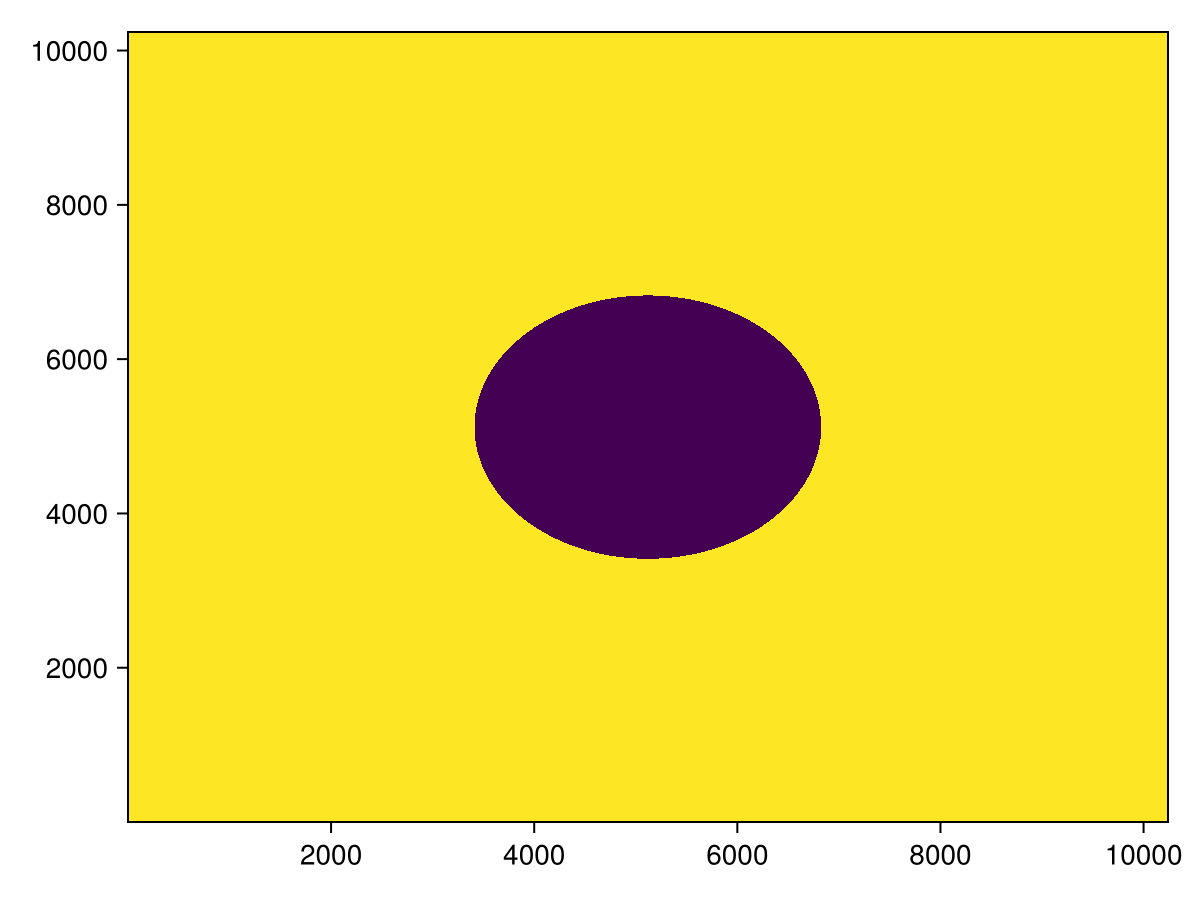

In [17]:
# initialize current and previous states to the same state
curr, prev = initialize(nx, ny)

show_heatmap(curr)

Initial average temperature: 59.76400241851807


Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


Final average temperature: 59.66948531363336
 43.267232 seconds (1.90 M allocations: 1.686 GiB, 0.30% gc time, 3.80% compilation time)


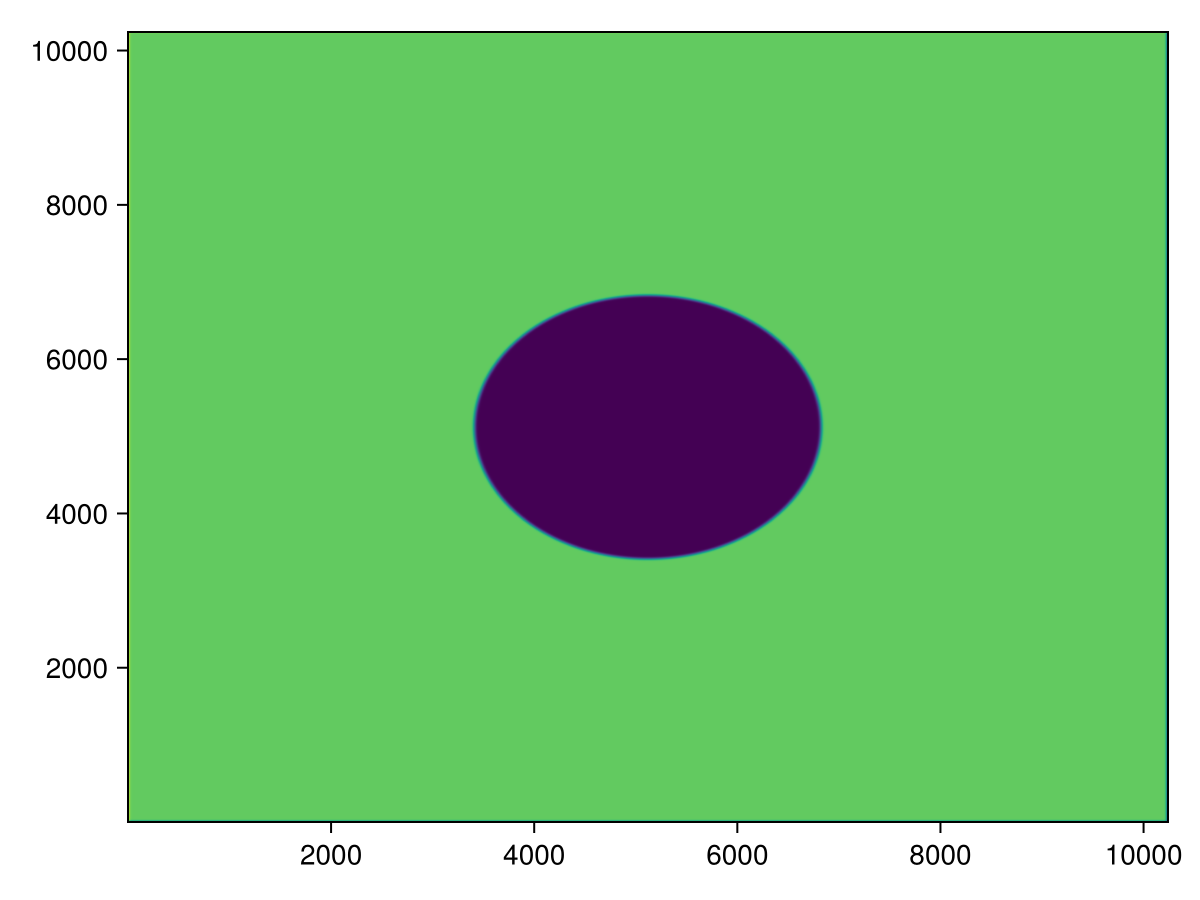

In [18]:
# simulate temperature evolution for nsteps
@time simulate_cpu!(curr, prev, nsteps)

show_heatmap(curr)

In [28]:
function calculate_cuda!(currdata, prevdata, dx2, dy2, nx, ny, a, dt)
    i = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    j = (blockIdx().y - 1) * blockDim().y + threadIdx().y
    if i > 1 && j > 1 && i < nx+2 && j < ny+2
        @inbounds xderiv = (prevdata[i-1, j] - 2.0 * prevdata[i, j] + prevdata[i+1, j]) / dx2
        @inbounds yderiv = (prevdata[i, j-1] - 2.0 * prevdata[i, j] + prevdata[i, j+1]) / dy2
        @inbounds currdata[i, j] = prevdata[i, j] + a * dt * (xderiv + yderiv)
    end
    
    return
end

calculate_cuda! (generic function with 1 method)

In [29]:
function simulate_gpu!(curr::Field, prev::Field, nsteps::Integer)
    println("Initial average temperature: $(average_temperature(curr))")

    # Diffusion constant
    α = 0.5
    # Largest stable time step
    dt = curr.dx^2 * curr.dy^2 / (2.0 * α * (curr.dx^2 + curr.dy^2))
    
    # display a nice progress bar
    p = Progress(nsteps)

    for i = 1:nsteps
        # calculate new state based on previous state
        
        nx, ny = size(curr.data) .- 2   
        xthreads = ythreads = 32
        xblocks, yblocks = cld(curr.nx, xthreads), cld(curr.ny, ythreads)
        @cuda threads=(xthreads, ythreads) blocks = (xblocks, yblocks) calculate_cuda!(curr.data, prev.data, curr.dx^2, curr.dy^2, nx, ny, α, dt)

        # swap current and previous fields
        swap_fields!(curr, prev)

        # increment the progress bar
        next!(p)
    end 

    println("Final average temperature: $(average_temperature(curr))")
end

simulate_gpu! (generic function with 1 method)

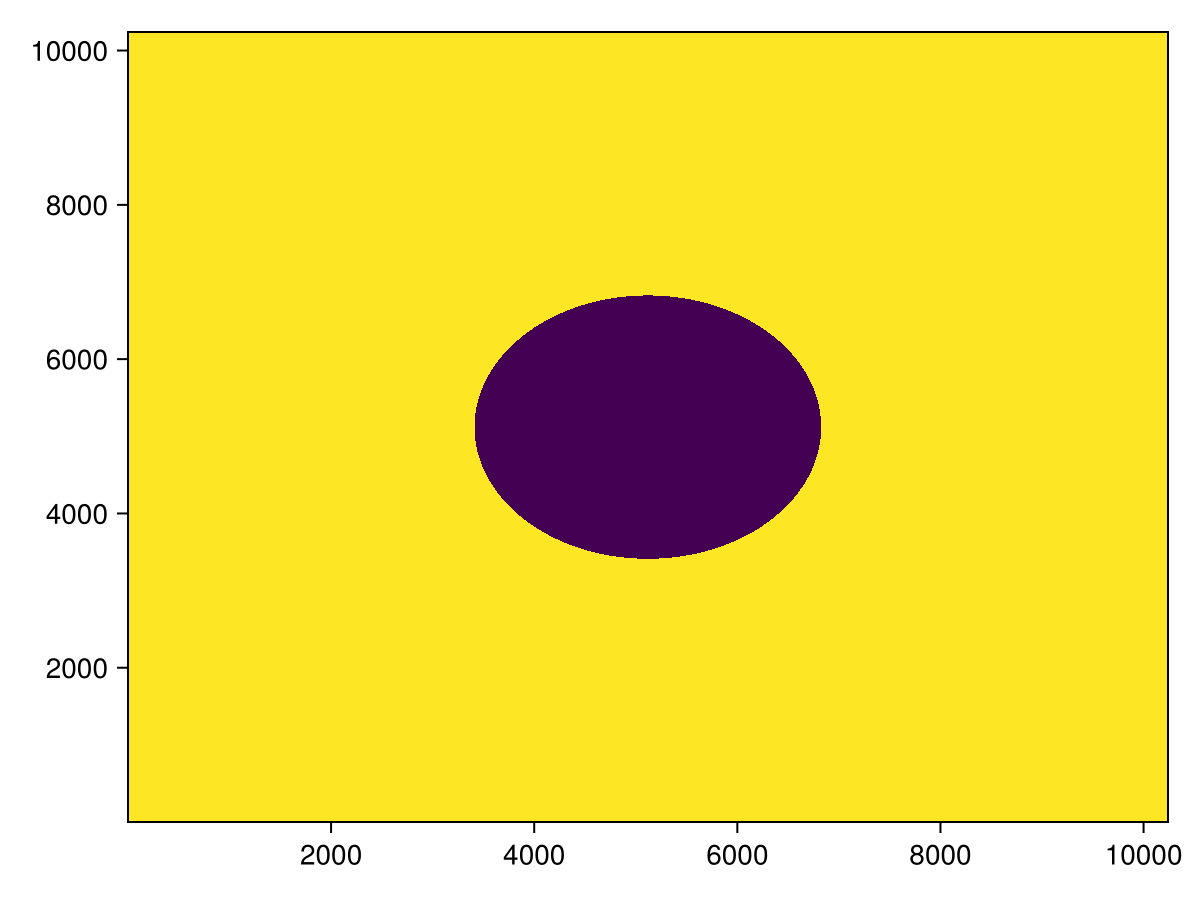

In [46]:
# initialize data on CPU and move it to GPU
curr, prev = initialize(nx, ny, CuArray)

show_heatmap(curr)

Initial average temperature: 59.76400241851807
Final average temperature: 59.734468711088795
  1.452977 seconds (9.51 k allocations: 319.664 KiB)


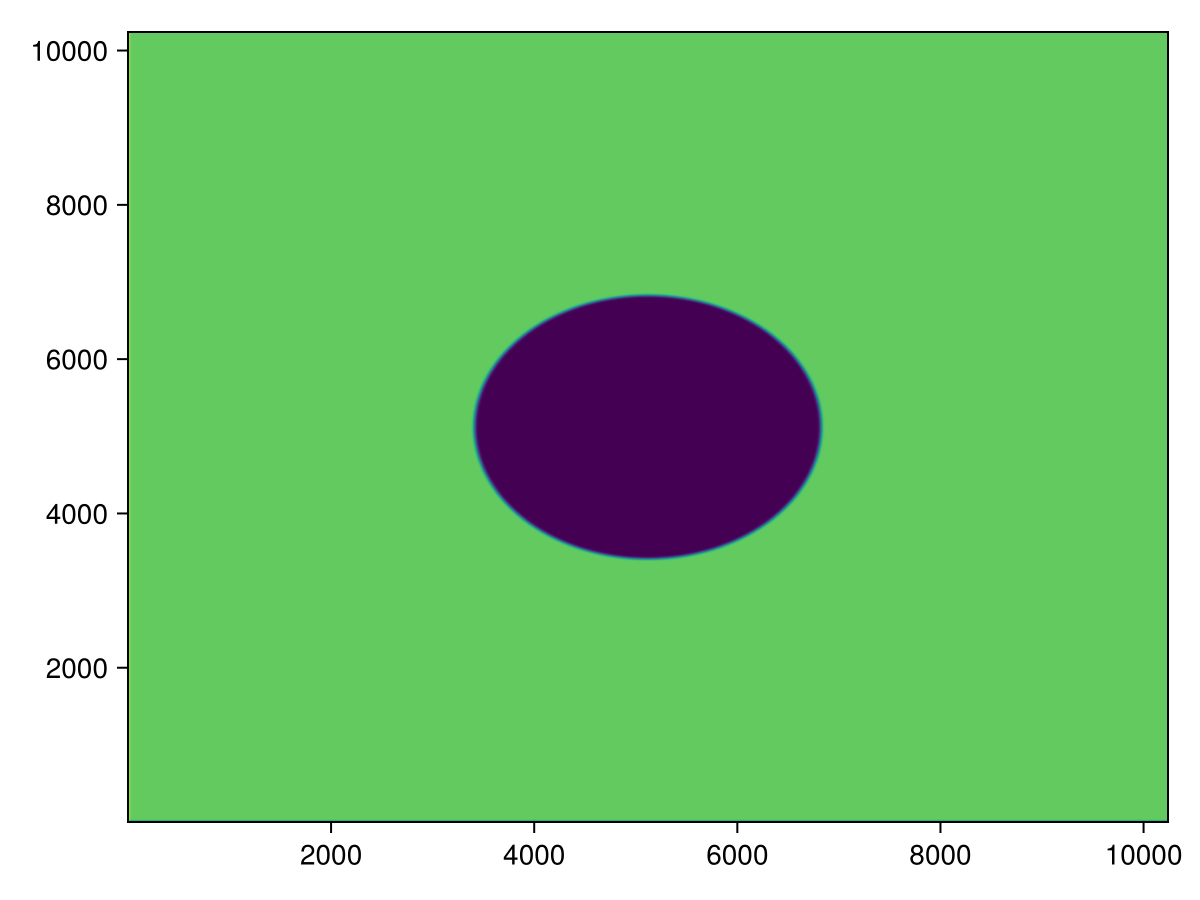

In [47]:
# simulate temperature evolution for nsteps
@time simulate_gpu!(curr, prev, nsteps)

show_heatmap(curr)

Initial average temperature: 59.734468711088795
Final average temperature: 59.663490843418884
 13.677775 seconds (90.55 k allocations: 2.922 MiB)


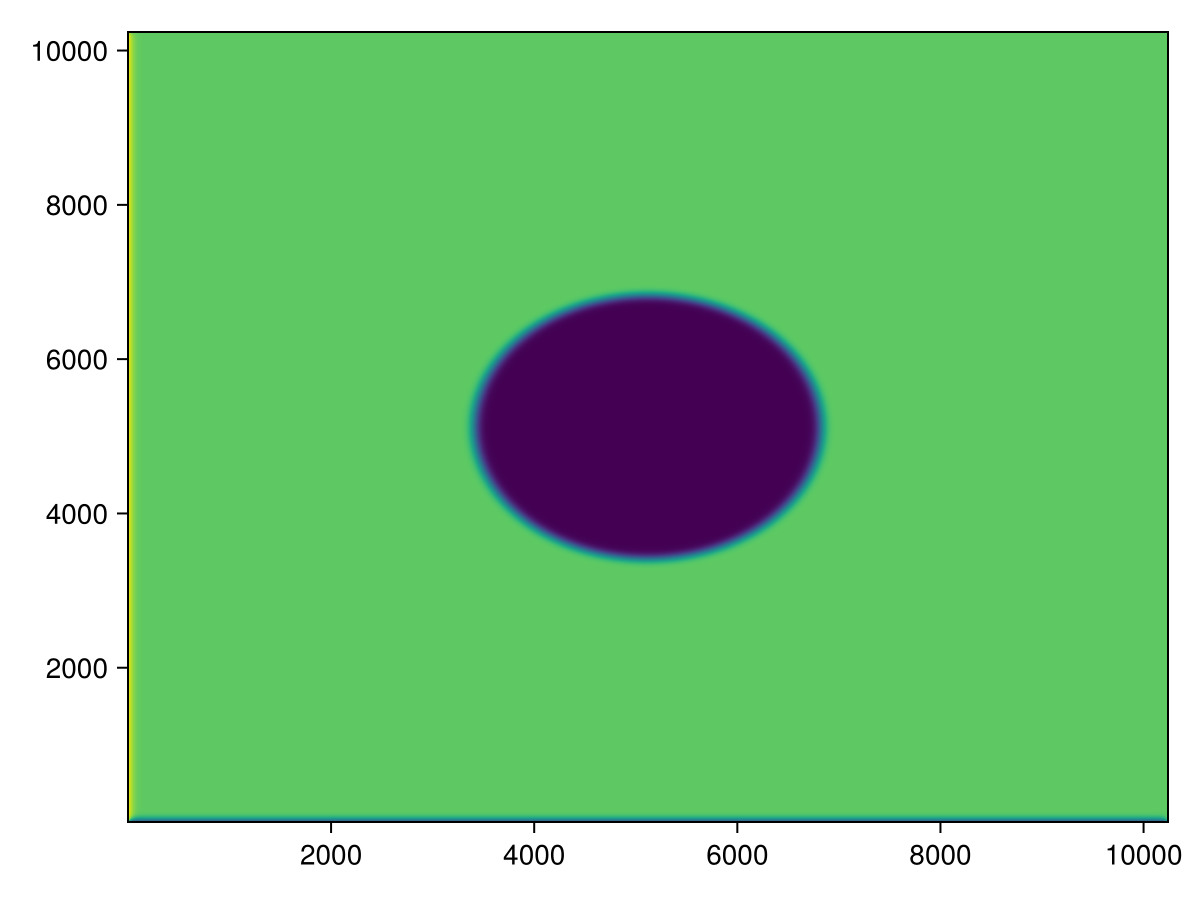

In [48]:
# simulate temperature evolution for 5000 additional steps
@time simulate_gpu!(curr, prev, 5000)

show_heatmap(curr)

In [35]:
@kernel function calculate_kernel!(currdata, prevdata, dx2, dy2, nx, ny, a, dt)
    i, j = @index(Global, NTuple)
    
    if i > 1 && j > 1 && i < nx+2 && j < ny+2
        @inbounds xderiv = (prevdata[i-1, j] - 2.0 * prevdata[i, j] + prevdata[i+1, j]) / dx2
        @inbounds yderiv = (prevdata[i, j-1] - 2.0 * prevdata[i, j] + prevdata[i, j+1]) / dy2
        @inbounds currdata[i, j] = prevdata[i, j] + a * dt * (xderiv + yderiv)
    end
end

calculate_kernel! (generic function with 4 methods)

In [36]:
function simulate_KA!(curr::Field, prev::Field, nsteps::Integer)
    println("Initial average temperature: $(average_temperature(curr))")

    # Diffusion constant
    α = 1.0    
    # Largest stable time step
    dt = curr.dx^2 * curr.dy^2 / (2.0 * α * (curr.dx^2 + curr.dy^2))
    
    # display a nice progress bar
    p = Progress(nsteps)

    for i = 1:nsteps
        # calculate new state based on previous state
        
        nx, ny = size(curr.data) .- 2  

        workgroupsize = (32, 32)
        kernel! = calculate_kernel!(Backend, workgroupsize)
        kernel!(curr.data, prev.data, curr.dx^2, curr.dy^2, nx, ny, α, dt, ndrange=(nx, ny))
        KernelAbstractions.synchronize(Backend)

        # swap current and previous fields
        swap_fields!(curr, prev)

        # increment the progress bar
        next!(p)
    end 

    println("Final average temperature: $(average_temperature(curr))")
end

simulate_KA! (generic function with 1 method)

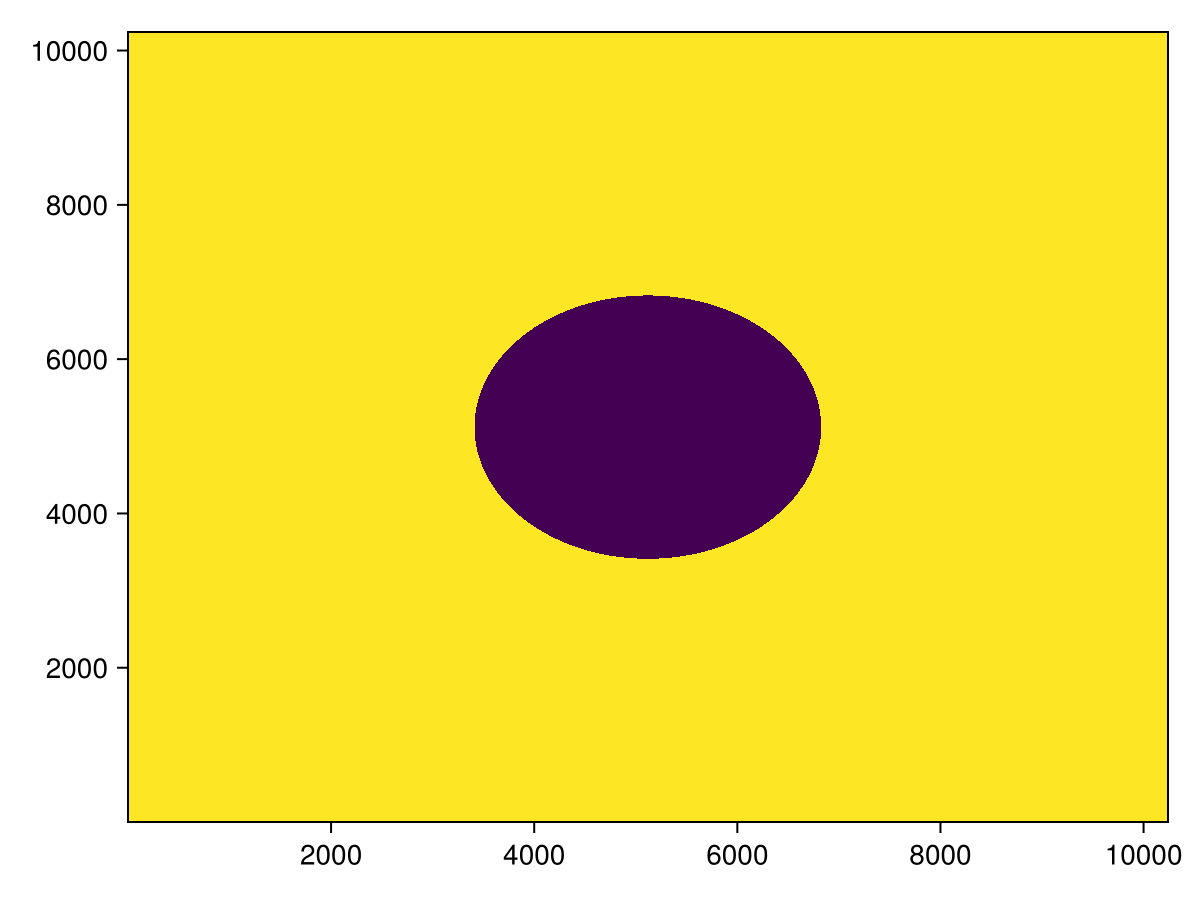

In [43]:
# initialize data on CPU and move it to GPU
curr, prev = initialize(nx, ny, ArrayKA)

show_heatmap(curr)

Initial average temperature: 59.76400241851807


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Final average temperature: 59.734468711088795
  1.675810 seconds (43.77 k allocations: 1.437 MiB)


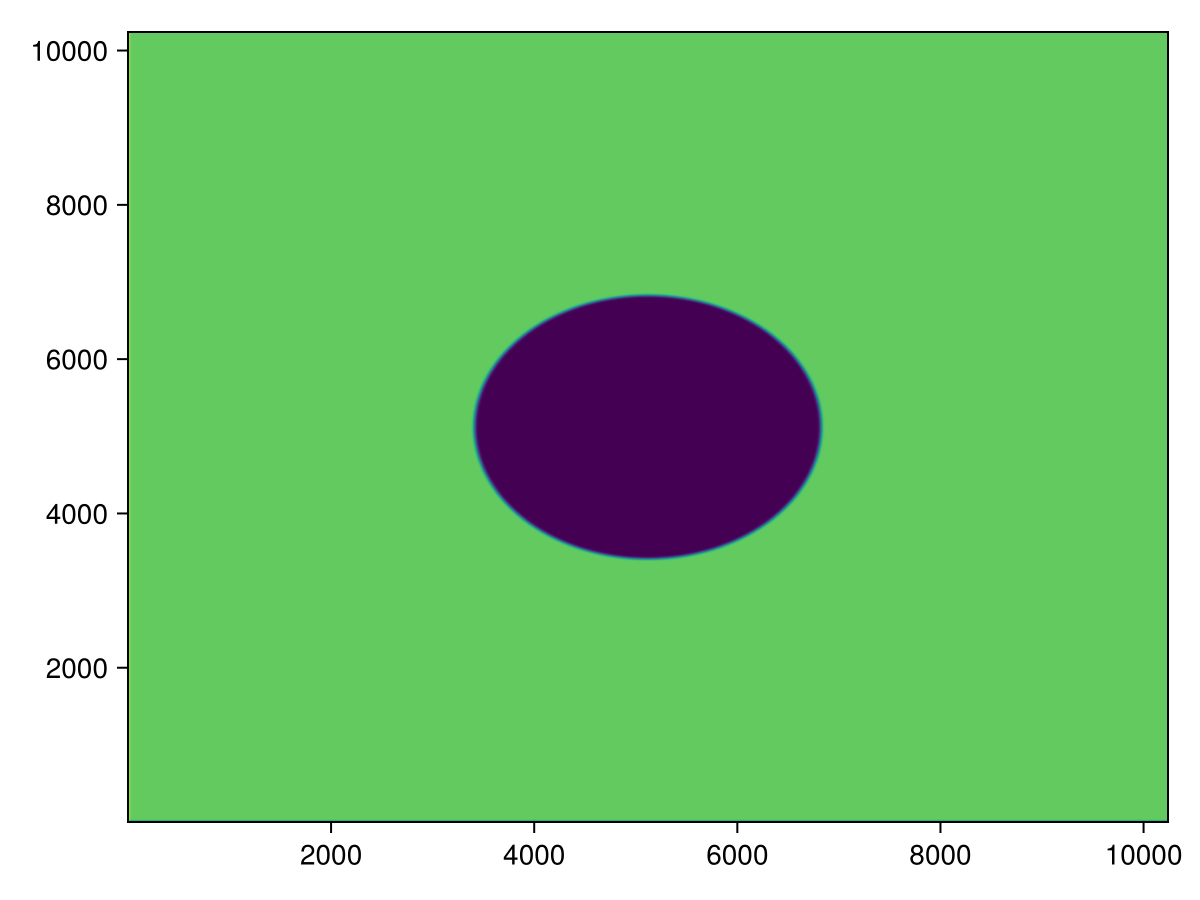

In [44]:
# simulate temperature evolution for nsteps
@time simulate_KA!(curr, prev, nsteps)

show_heatmap(curr)

Initial average temperature: 59.734468711088795


Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


Final average temperature: 59.663490843418884
 15.625046 seconds (431.18 k allocations: 13.933 MiB)


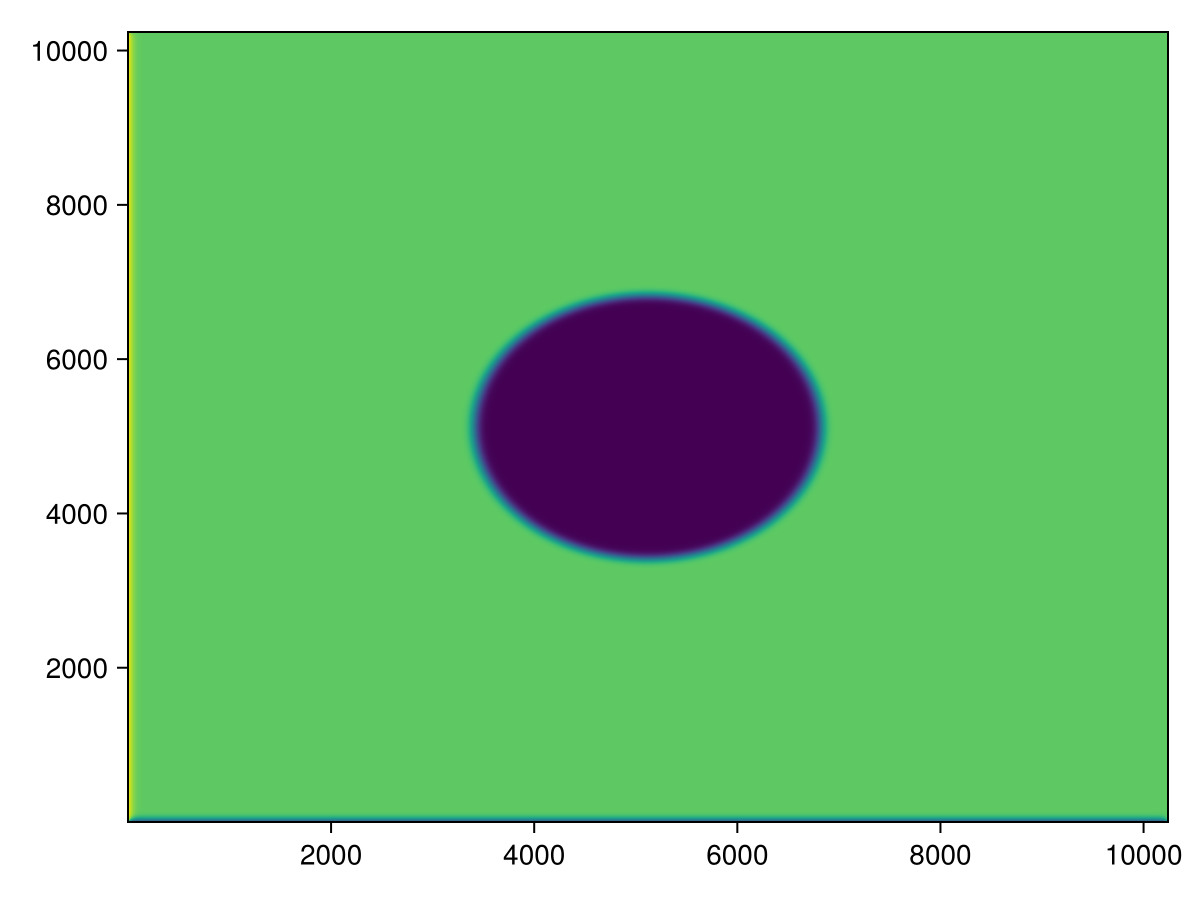

In [45]:
# simulate temperature evolution for 5000 additional steps
@time simulate_KA!(curr, prev, 5000)

show_heatmap(curr)

In [ ]:
function laplacian(i, j, k, var)
    @inbounds l = var[i - 1, j, k] + var[i + 1, j, k] + var[i, j - 1, k] +
                  var[i, j + 1, k] + var[i, j, k - 1] + var[i, j, k + 1] -
                  6.0 * var[i, j, k]
    return l / 6.0
end

In [24]:
function calculate_gs_cuda!(u_curr, u_prev, v_curr, v_prev, dx2, dy2, nx, ny, a, dt)
    i = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    j = (blockIdx().y - 1) * blockDim().y + threadIdx().y
    if i > 1 && j > 1 && i < nx+2 && j < ny+2
        @inbounds u_xderiv = (u_prev[i-1, j] - 2.0 * u_prev[i, j] + u_prev[i+1, j]) / dx2
        @inbounds u_yderiv = (u_prev[i, j-1] - 2.0 * u_prev[i, j] + u_prev[i, j+1]) / dy2
        @inbounds u_curr[i, j] = u_prev[i, j] + a * dt * (u_xderiv + u_yderiv)
        @inbounds v_xderiv = (v_prev[i-1, j] - 2.0 * v_prev[i, j] + v_prev[i+1, j]) / dx2
        @inbounds v_yderiv = (v_prev[i, j-1] - 2.0 * v_prev[i, j] + v_prev[i, j+1]) / dy2
        @inbounds v_curr[i, j] = v_prev[i, j] + a * dt * (v_xderiv + v_yderiv)
    end
    
    return
end

calculate_gs_cuda! (generic function with 1 method)

In [25]:
function simulate_gs_gpu!(curr::Field, prev::Field, nsteps::Integer)
    println("Initial average temperature: $(average_temperature(curr))")

    # Diffusion constant
    α = 0.5
    # Largest stable time step
    dt = curr.dx^2 * curr.dy^2 / (2.0 * α * (curr.dx^2 + curr.dy^2))
    
    # display a nice progress bar
    p = Progress(nsteps)

    for i = 1:nsteps
        # calculate new state based on previous state
        
        nx, ny = size(curr.data1) .- 2   
        xthreads = ythreads = 32
        xblocks, yblocks = cld(curr.nx, xthreads), cld(curr.ny, ythreads)
        @cuda threads=(xthreads, ythreads) blocks = (xblocks, yblocks) calculate_cuda!(curr.data1, prev.data1, curr.data2, prev.data2, curr.dx^2, curr.dy^2, nx, ny, α, dt)

        # swap current and previous fields
        swap_fields!(curr, prev)

        # increment the progress bar
        next!(p)
    end 

    println("Final average temperature: $(average_temperature(curr))")
end

simulate_gs_gpu! (generic function with 1 method)

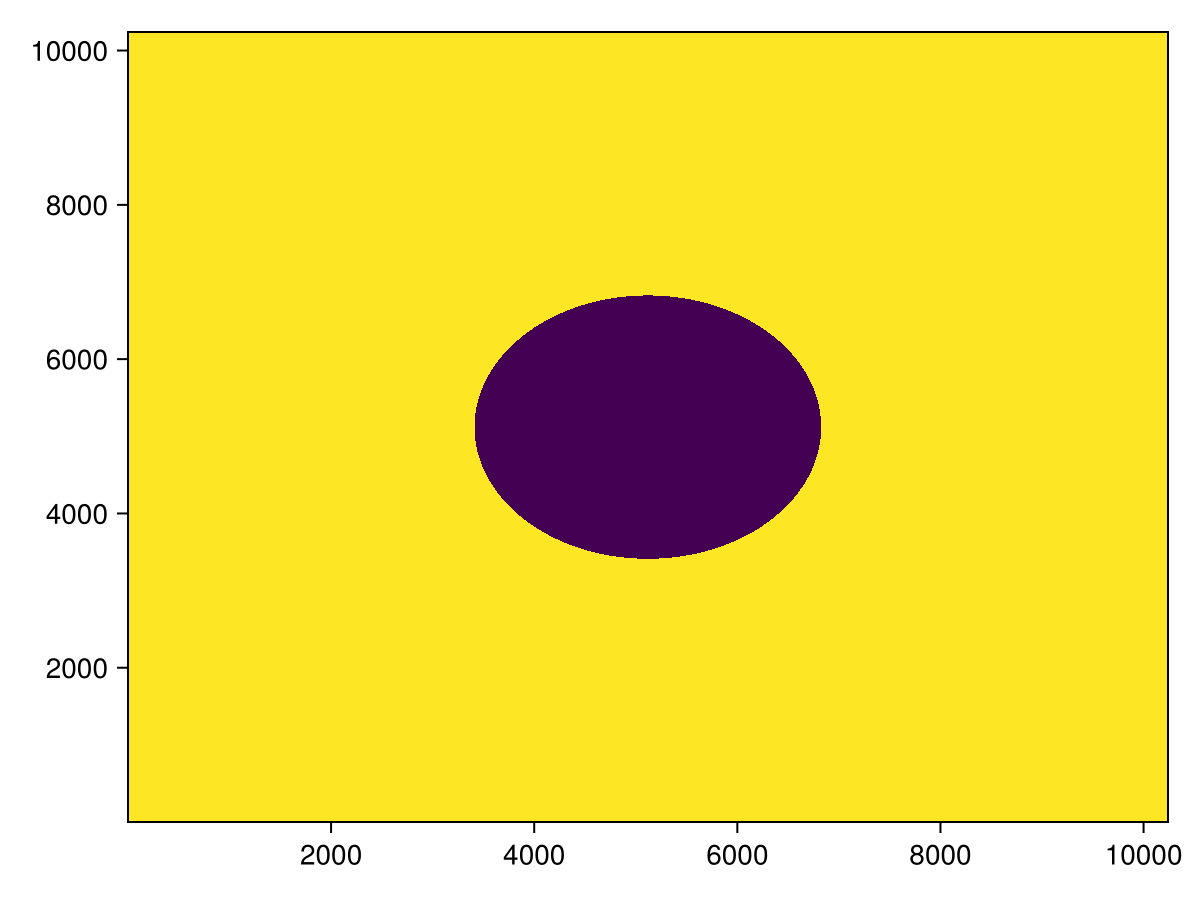

In [27]:
# initialize data on CPU and move it to GPU
curr, prev = initialize_gs(nx, ny, CuArray)

show_heatmap(curr)